# <a name="0"><font color='Blue'>**Rossmann Store Sales**</font></a>
## **A Time Series problem.**
### The competition page from [this](https://www.kaggle.com/competitions/rossmann-store-sales) link.

---

## **Abstract:**

**Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.**


**The notebook explores different methods to forecast sales for Rossmann stores. The models evaluated include machine learning (ML) models and time series models, as well as simple models for comparison.**

---

## **Table of Contents of the notebook:**

1. <a href="#1">**Setup**</a>
2. <a href="#2">**Reading the dataset**</a>
3. <a href="#3">**Data Preperation**</a>
4. <a href="#4">**Train Test Split**</a>
5. <a href="#5">**Gaining Insights (EDA)**</a>
6. <a href="#6">**Time Series Models**</a>
7. <a href="#7">**Machine Leaning Model**</a>
8. <a href="#8">**Choosing Best Model**</a>

---

# 1. <a name="1">**Setup**</a>
(<a href="#0">Go to top</a>)

**Installing and Importing used libraries.**

In [2]:
# Install pmdarima
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:0000:010:01


In [3]:
# Install statsmodels
!pip install git+https://github.com/statsmodels/statsmodels.git@74836e9cf2198ac7a930146405da7239c0823a9b#egg=statsmodels

  Cloning https://github.com/statsmodels/statsmodels.git (to revision 74836e9cf2198ac7a930146405da7239c0823a9b) to /tmp/pip-install-q0za7zxh/statsmodels_f03c039b4c0d4be6b5de51893fe45ff0
  Running command git clone --filter=blob:none --quiet https://github.com/statsmodels/statsmodels.git /tmp/pip-install-q0za7zxh/statsmodels_f03c039b4c0d4be6b5de51893fe45ff0
  Running command git rev-parse -q --verify 'sha^74836e9cf2198ac7a930146405da7239c0823a9b'
  Running command git fetch -q https://github.com/statsmodels/statsmodels.git 74836e9cf2198ac7a930146405da7239c0823a9b
  Running command git checkout -q 74836e9cf2198ac7a930146405da7239c0823a9b
  Resolved https://github.com/statsmodels/statsmodels.git to commit 74836e9cf2198ac7a930146405da7239c0823a9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statsmodels: filename=statsmodels-0.14.0.dev0+345.g74836e9cf-cp310-cp310-linux_x86_64.whl si

In [138]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from lightgbm import LGBMRegressor
from prophet import Prophet
logging.getLogger("cmdstanpy").disabled = True 
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from itertools import product

---

# 2. <a name="2">**Reading the dataset**</a>
(<a href="#0">Go to top</a>)

In [145]:
df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', index_col = "Date", low_memory=False, parse_dates=['Date'])

In [146]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


---

# 3. <a name="3">**Data preperation**</a>
(<a href="#0">Go to top</a>)

## A- Choose The Store We will work on (Store 1)

In [148]:
df = df[df["Store"] == 1]

## B- Check for nulls

In [149]:
df.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## C- Make freq as daily

In [150]:
df = df.asfreq('D')

In [151]:
df.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## D- Remove Customers column as it won't be available in production

In [152]:
df.drop(["Customers"], axis=1,inplace=True)

## E- Sort by date

In [153]:
df.sort_values(by="Date", inplace=True)

---

# 4. <a name="4">**Train Test Split**</a>
(<a href="#0">Go to top</a>)

### <font color='green'>**Split data into train and test 80:20**</font>

In [154]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

---

# 5. <a name="5">**Gaining Insights (EDA)**</a>
(<a href="#0">Go to top</a>)

## A- Plot Sales (All train data) 

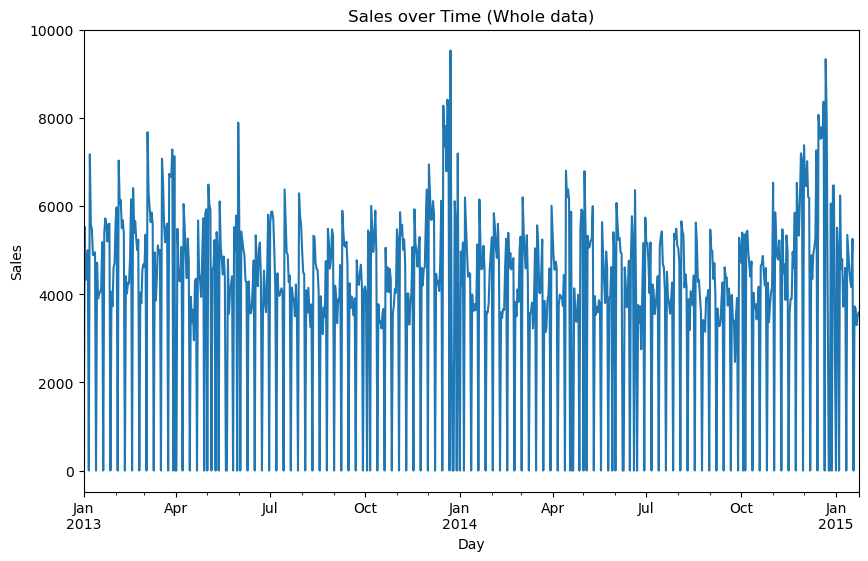

In [155]:
plt.figure(figsize=(10, 6))
train_data['Sales'].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (Whole data)')
plt.show()

## B- Plot Sales (One Month) 

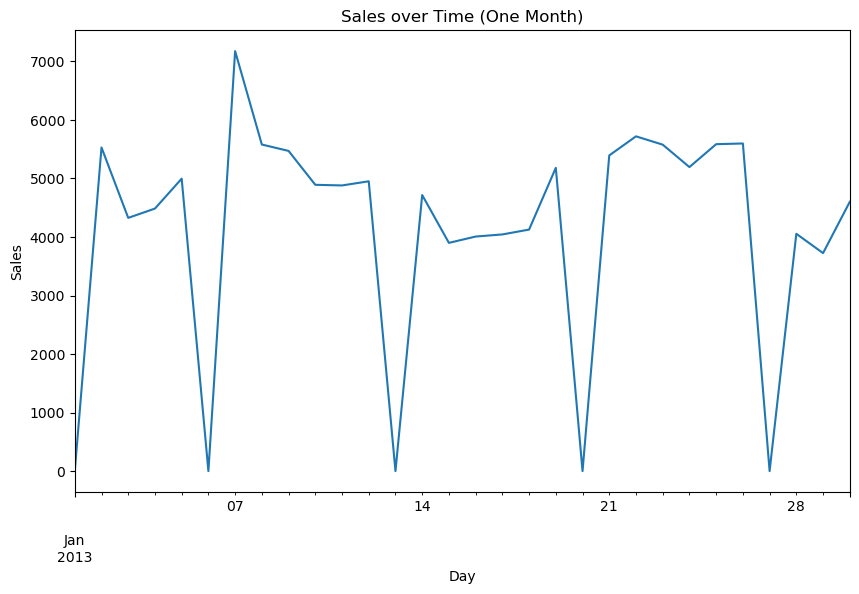

In [156]:
plt.figure(figsize=(10, 6))
train_data['Sales'][:30].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (One Month)')
plt.show()

### <font color='green'>**It seems that Friday is the off day of the stores**</font>

## C- Plot Sales (One Year) 

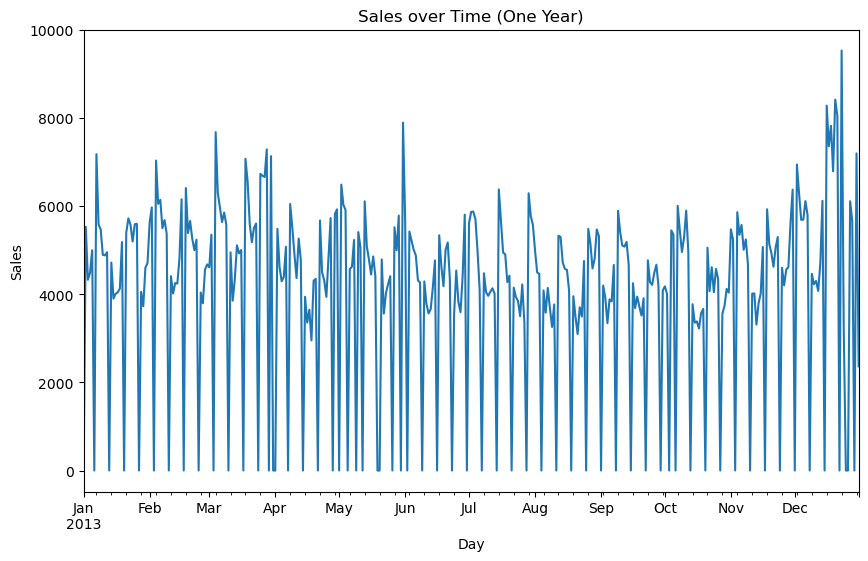

In [157]:
plt.figure(figsize=(10, 6))
train_data['Sales'][:365].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (One Year)')
plt.show()

### <font color='green'>**We see a peak in sales in Dec**</font>

## D- Extract additional columns 

In [158]:
train_data['year'] = train_data.index.year
train_data['month'] = train_data.index.month
train_data['day'] = train_data.index.day

# Convert the columns to integers
train_data['year'] = train_data['year'].astype(int)
train_data['month'] = train_data['month'].astype(int)
train_data['day'] = train_data['day'].astype(int)

In [159]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2013-01-01 to 2015-01-23
Freq: D
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          753 non-null    int64 
 1   DayOfWeek      753 non-null    int64 
 2   Sales          753 non-null    int64 
 3   Open           753 non-null    int64 
 4   Promo          753 non-null    int64 
 5   StateHoliday   753 non-null    object
 6   SchoolHoliday  753 non-null    int64 
 7   year           753 non-null    int64 
 8   month          753 non-null    int64 
 9   day            753 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 64.7+ KB


## E- Plot sales by different dates values

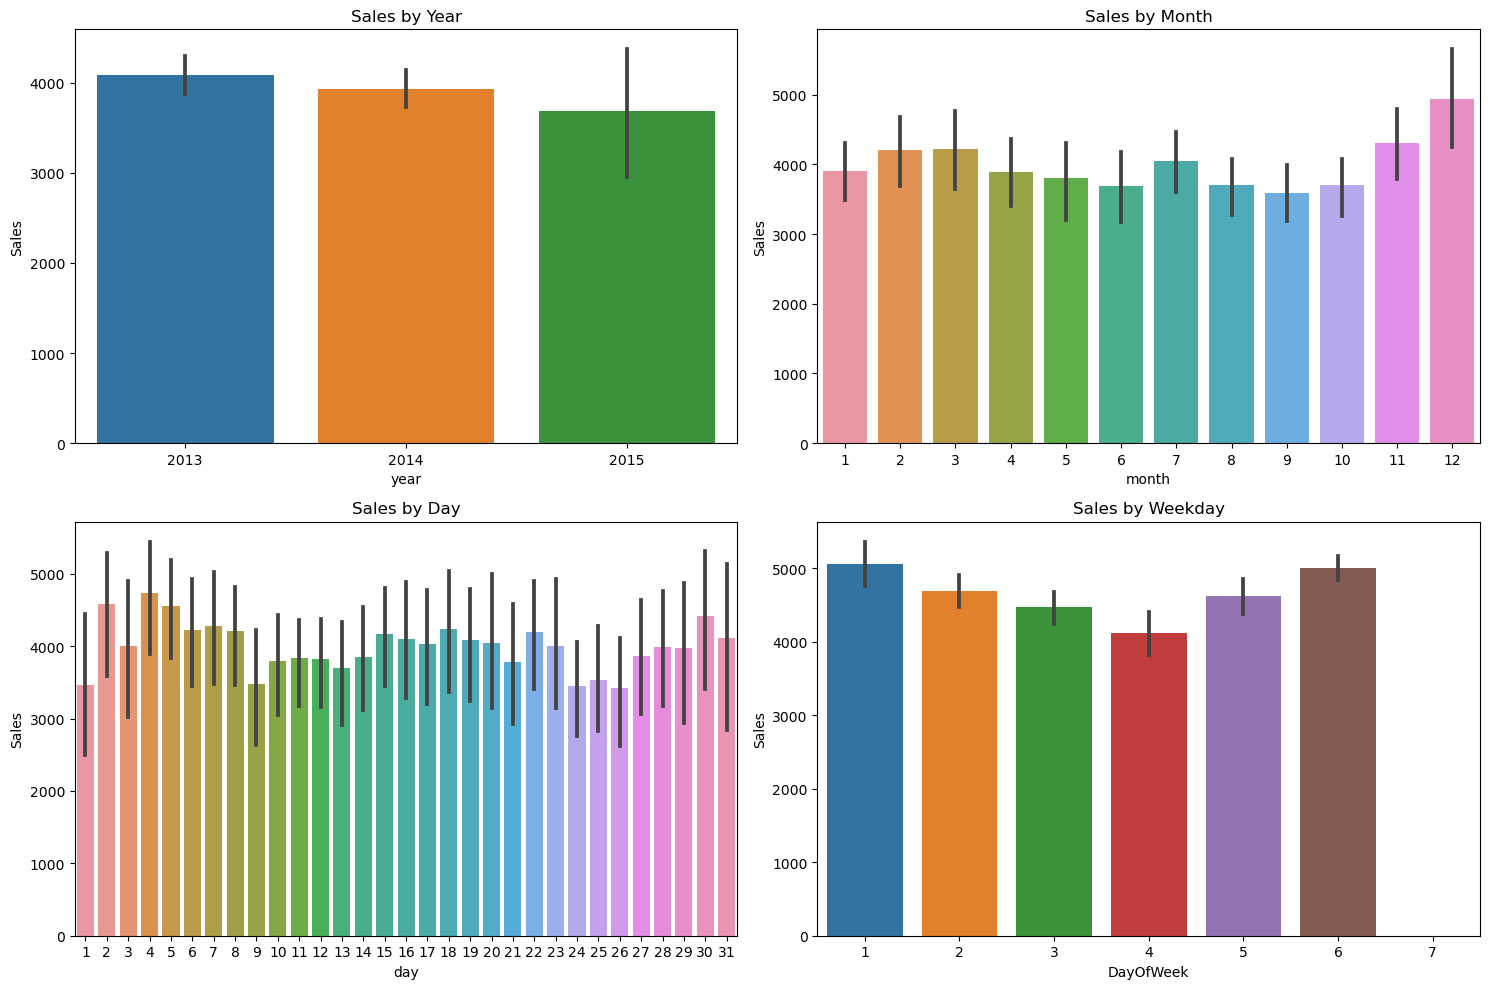

In [160]:
# Create a grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x='year',y="Sales", data=train_data, ax=axes[0, 0])
sns.barplot(x='month',y="Sales", data=train_data, ax=axes[0, 1])
sns.barplot(x='day',y="Sales", data=train_data, ax=axes[1, 0])
sns.barplot(x='DayOfWeek',y="Sales", data=train_data, ax=axes[1, 1])

# Set the titles for each chart
axes[0, 0].set_title('Sales by Year')
axes[0, 1].set_title('Sales by Month')
axes[1, 0].set_title('Sales by Day')
axes[1, 1].set_title('Sales by Weekday')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of bar charts
plt.show()

### <font color='green'>**The Insighst we gained:**<Br><Br>1. Sales decrease over the years<Br><Br>2. The peak of sales is on Nov and Dec<Br><Br>3. Sales increase in the opening and closing day of the week</font>

## F- Define Monthly seasonal plot

In [161]:
def monthly_quarter_line_plot(df,col_x,col_y,hue_col,title="Monthly"):
    plt.figure(figsize=(10,8))
    sns.lineplot(data=df, 
                 x=col_x, 
                 y=col_y, 
                 hue=hue_col, 
                 legend='full',palette="tab10")

    # add title
    plt.title(title+' Seasonal plot')

    # move the legend outside of the main figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

## G- plot Monthly seasonal

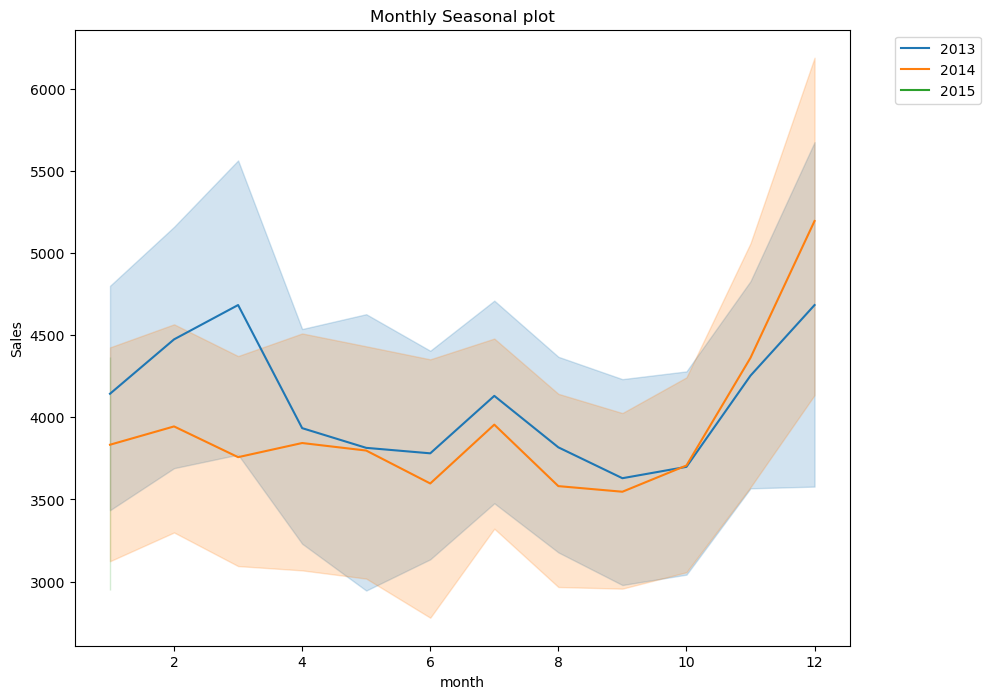

In [162]:
monthly_quarter_line_plot(train_data,"month","Sales","year",title="Monthly")

## H- Plot Sales in different conditions

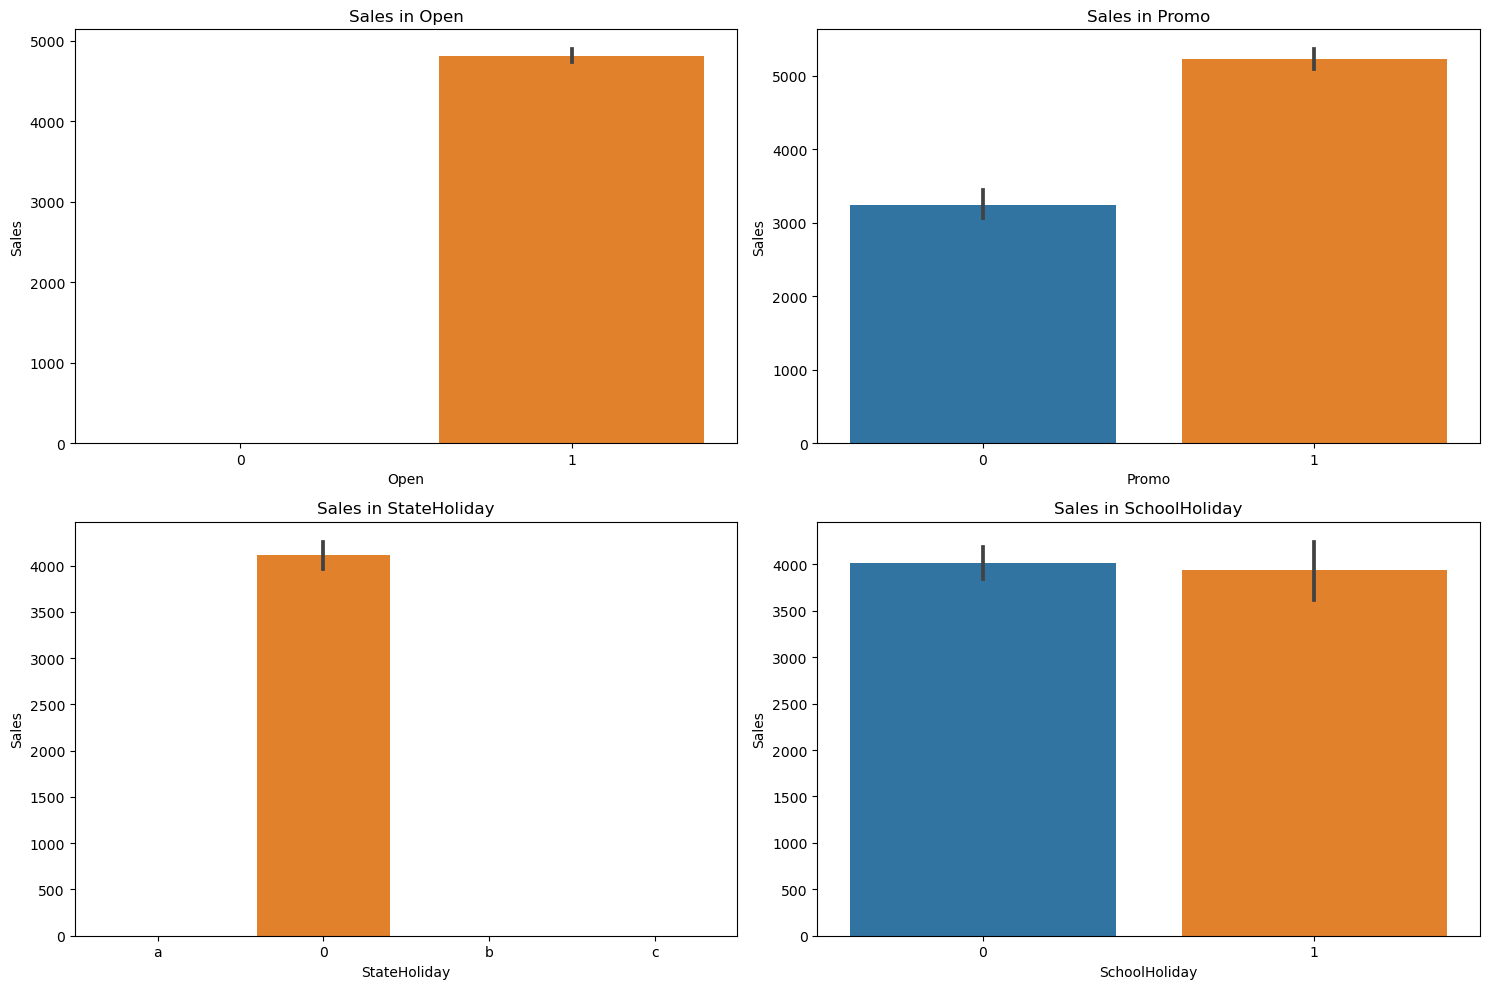

In [163]:
# Create a grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x='Open',y="Sales", data=train_data, ax=axes[0, 0])
sns.barplot(x='Promo',y="Sales", data=train_data, ax=axes[0, 1])
sns.barplot(x='StateHoliday',y="Sales", data=train_data, ax=axes[1, 0])
sns.barplot(x='SchoolHoliday',y="Sales", data=train_data, ax=axes[1, 1])

# Set the titles for each chart
axes[0, 0].set_title('Sales in Open')
axes[0, 1].set_title('Sales in Promo')
axes[1, 0].set_title('Sales in StateHoliday')
axes[1, 1].set_title('Sales in SchoolHoliday')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of bar charts
plt.show()

### <font color='green'>**Nothing unusual, no sales when store is closed, State holidays don't add new information, sales increase in promo, and Shool holidays don't make that difference**</font>

## I- Define histogram function

In [296]:
def histograms(df,col_name,bins_number=100,diff=False, xmin=-1000, xmax=1000):
    if diff:
        plt.figure(figsize=(8,6))
        plt.hist(df[col_name].diff(),bins=bins_number)
        plt.xlim(xmin,xmax)
        plt.show()
    else:
        plt.figure(figsize=(8,6))
        plt.hist(df[col_name],bins=bins_number)
        plt.show()

## J- Distribution of sales values differences (When the store is not closed)

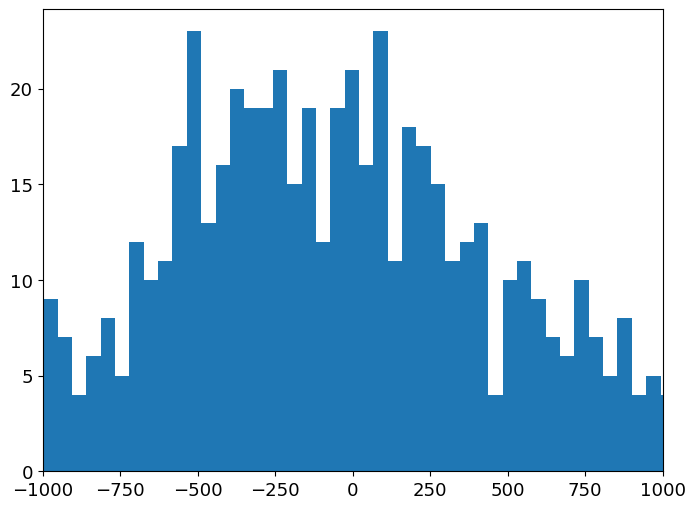

In [297]:
histograms(train_data[train_data["Sales"] != 0],"Sales",bins_number=200,diff=True)

## K- Distribution of sales values (When the store is not closed)

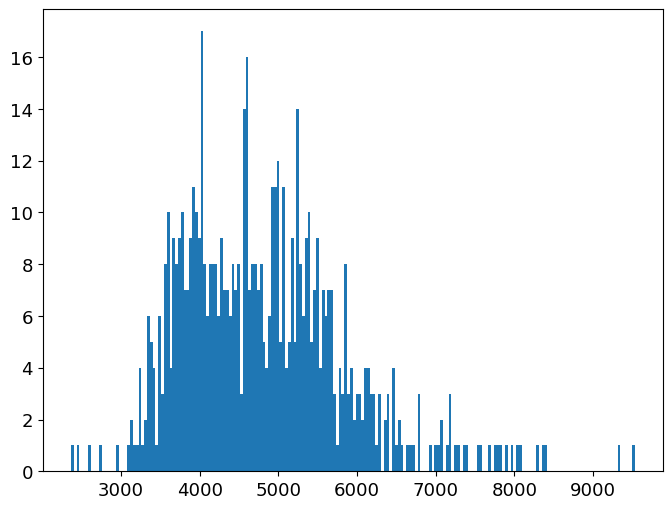

In [298]:
histograms(train_data[train_data["Sales"] != 0],"Sales",bins_number=200,diff=False)

---

# 6. <a name="6">**Time Series Models**</a>
(<a href="#0">Go to top</a>)

![](https://forums.fast.ai/uploads/default/original/2X/3/3c449523e3973a978d480854fd17af0299b5c9b7.png)

### Eval Metric (RMSPE):

In [167]:
def rmspe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

### Plot train vs test

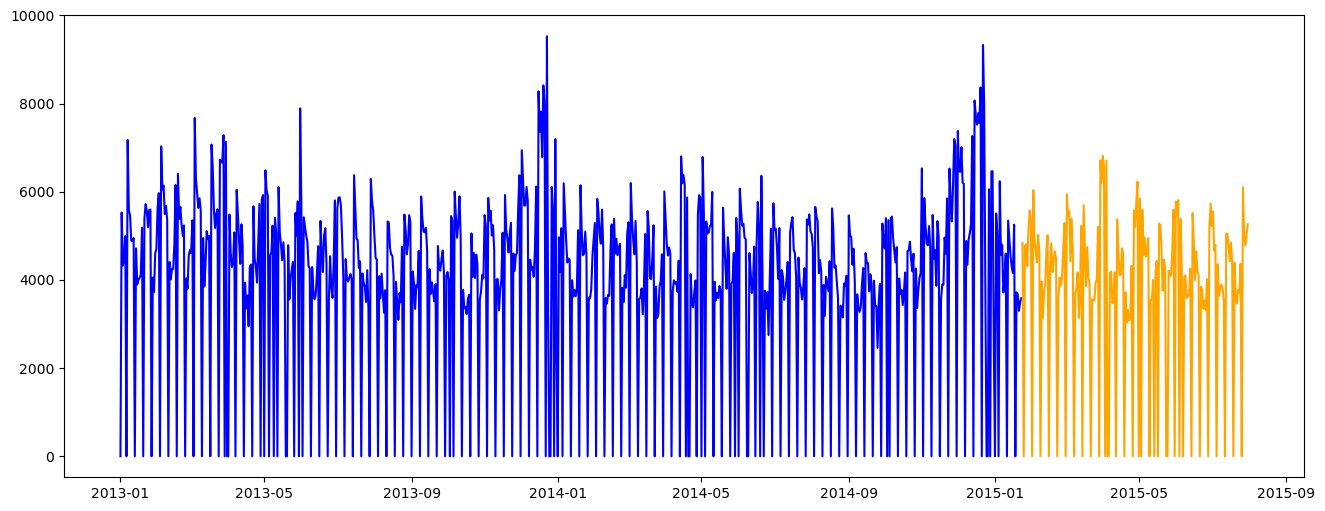

In [168]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes.plot(train_data["Sales"], label='Train',color='blue')
axes.plot(test_data["Sales"], label='Test',color='orange')
plt.show()

## **A- Simple Forecasting Models**

### Models Functions

In [233]:
def average_method(train_data,test_data):
    ## Average method 
    average_prediction = [np.mean(train_data)]*len(test_data)
    average_pred = pd.DataFrame(average_prediction)
    average_pred.index = test_data.index
    return average_pred.squeeze()

def naive_method(train_data,test_data):
    ##Naive method
    naiive_prediction = [train_data.iloc[-1]]*len(test_data)
    naiive_pred = pd.DataFrame(naiive_prediction)
    naiive_pred.index = test_data.index
    return naiive_pred.squeeze()

def seasonal_naive(train_data,test_data):
    ##SEasonal_NAive
    dates = (test_data.index - np.timedelta64(1, 'Y')).values.astype('datetime64[D]')
    dates = dates + np.timedelta64(2,'D')
    seasonal_naive_prediction = train_data[train_data.index.isin(dates)].values # seasonal naive prediction
    seasonal_naive = pd.DataFrame(seasonal_naive_prediction).set_index(test_data.index)
    return seasonal_naive.squeeze()

def drift_method(train_data,test_data):
    # Get the slope
    y_t = train_data[len(train_data)-1]
    m = (y_t - train_data[1]) / len(train_data)
    h = np.linspace(0,len(test_data)-1, len(test_data))
    drift_prediction = y_t + m * h
    drift_pred = pd.DataFrame(drift_prediction).set_index(test_data.index)
    return drift_pred.squeeze()

### Get predictions

In [234]:
average_pred = average_method(train_data["Sales"],test_data["Sales"])
naiive_pred = naive_method(train_data["Sales"],test_data["Sales"])
seasonal_naive_pred = seasonal_naive(train_data["Sales"],test_data["Sales"])
drift_pred = drift_method(train_data["Sales"],test_data["Sales"])

### Make Value of prediction = 0 when The Store is not open

In [235]:
for pred in [average_pred,naiive_pred,seasonal_naive_pred,drift_pred]:
    pred[test_data["Open"] == 0] = 0

### Plot predicions

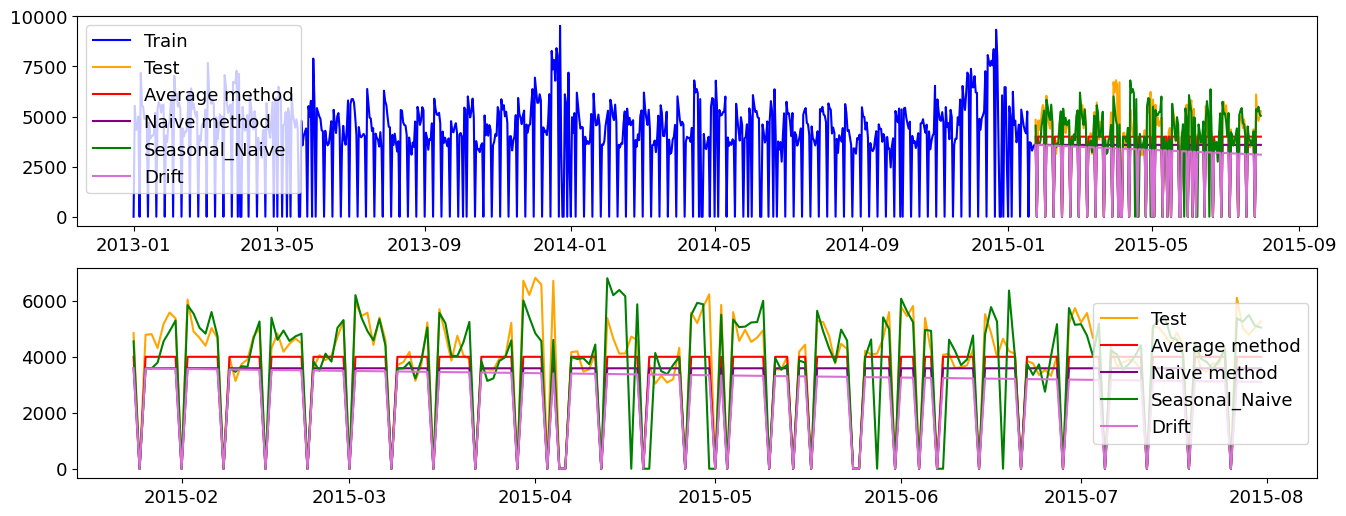

In [236]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(average_pred,label="Average method",color='red')
axes[0].plot(naiive_pred,label="Naive method",color='purple')
axes[0].plot(seasonal_naive_pred, label='Seasonal_Naive',color='green')
axes[0].plot(drift_pred,label='Drift',color='orchid')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(average_pred,label="Average method",color='red')
axes[1].plot(naiive_pred,label="Naive method",color='purple')
axes[1].plot(seasonal_naive_pred, label='Seasonal_Naive',color='green')
axes[1].plot(drift_pred,label='Drift',color='orchid')
axes[1].legend(loc='best')
plt.show()

### Evaluate predictions

In [238]:
print(f"""
RMSPE for average method:{rmspe( average_pred, test_data[["Sales"]])}
RMSPE for Naive method:{rmspe( naiive_pred, test_data[["Sales"]])}
RMSPE for Seasonal_Naive method:{rmspe( seasonal_naive_pred, test_data[["Sales"]])}
RMSPE for Drift method:{rmspe( drift_pred, test_data[["Sales"]])}""")


RMSPE for average method:0.2700499184008197
RMSPE for Naive method:0.3848913363901235
RMSPE for Seasonal_Naive method:0.2785373532445238
RMSPE for Drift method:0.47645674308932817


### <font color='green'>**Seasonal naive method is doing a very good job actually!**</font>

## **B- MSTL Model**

In [173]:
mstl = MSTL(train_data["Sales"], periods=(7, 30, 365), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit() 

### <font color='green'>**Multiple seasonal periods are allowed, so we will choose weekly, monthly and anually**</font>

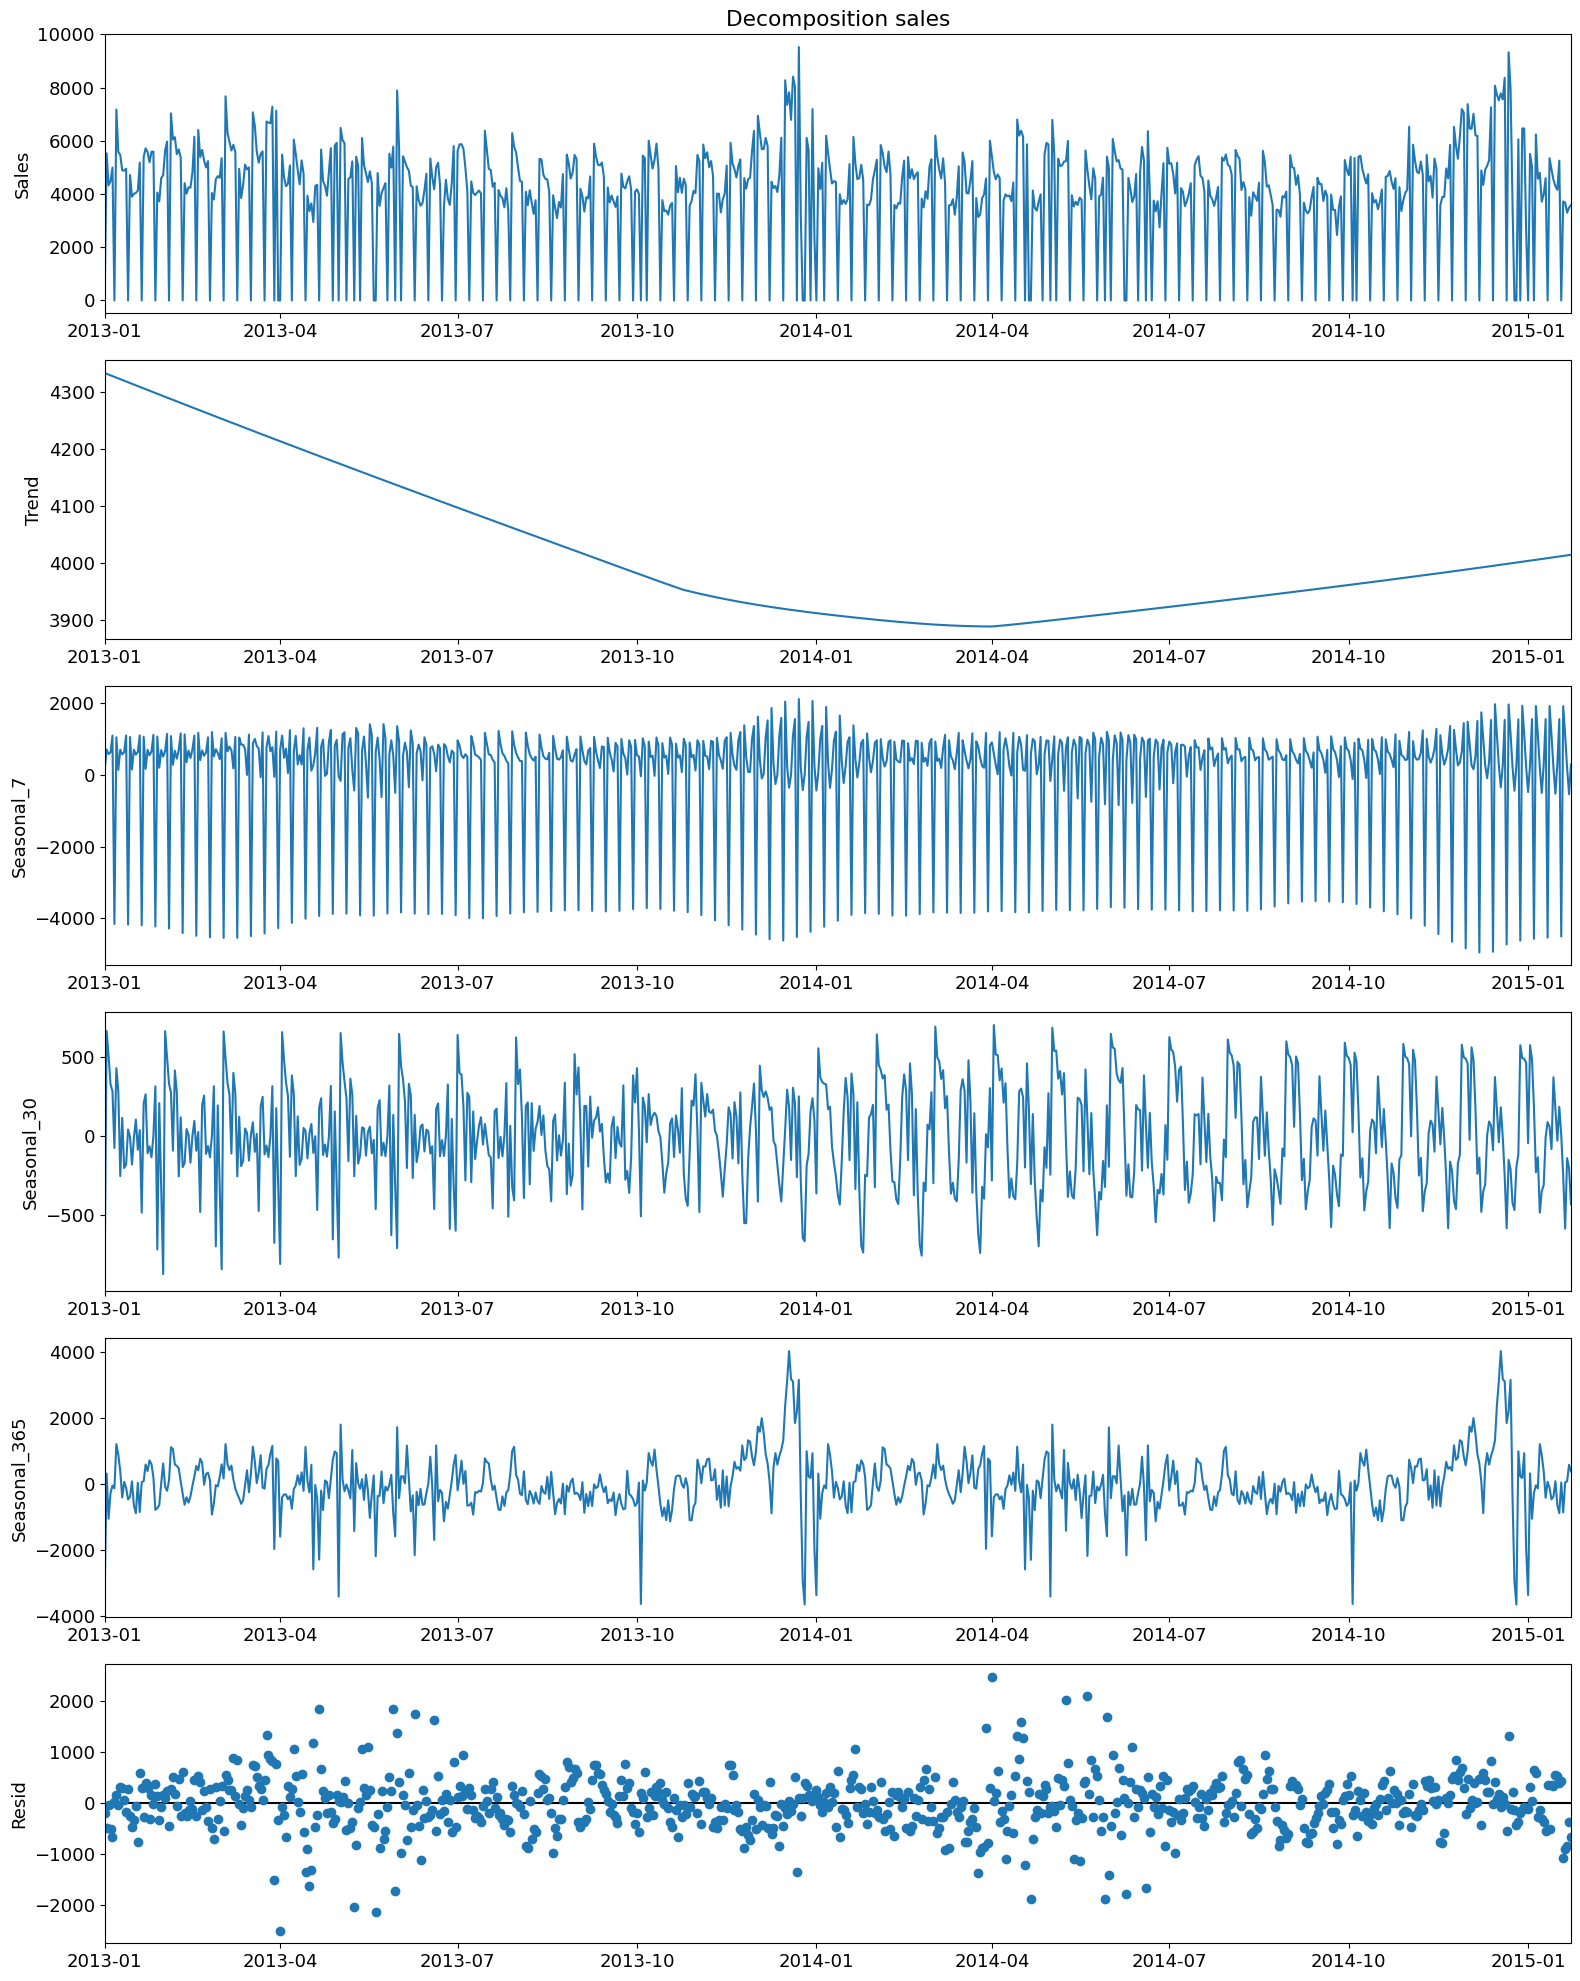

In [174]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

axs[0].set_ylabel("Sales")
axs[0].set_title("Decomposition sales")

plt.tight_layout()

<div class="alert-info">
<font color='black'>Fitting functions on seasonal and trend decomposition of time series (STL) can be challenging, Despite the challenges, STL decomposition remains a useful technique for analyzing and modeling time series data, especially when dealing with seasonal and trend components</font>
</div>

## **C- Arima models**

### Define kpss_test function

In [175]:
def kpss_test(data,threshold=0.05,regression="c"):
    result = kpss(data,regression="c")
    #print(result)
    # Print test results
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))
    if result[1]<=threshold:
        print("The data is not stationary")
    else:
        print("The data is stationary")

### Define adf_test function

In [176]:
def adf_test(data,threshold=0.05):
    # Perform ADF test
    result = adfuller(data,autolag="AIC")
    
    # Print test results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    
    if result[1] <= threshold:
        print("Conclusion:====>") 
        print("Reject the null hypothesis") 
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis") 
        print("Data is non-stationary")

### Define autocorrelatin_graphs function

In [177]:
def autocorrelatin_graphs(value,n_lags,title_text):
    fig, axes = plt.subplots(3,1,dpi=80)
    fig.set_figheight(12)
    fig.set_figwidth(16)
    value_plot = axes[0].plot(value)
    plt.title(f'{title_text}')
    acf_plot = plot_acf(value, lags=n_lags, title=f'Autocorrelation in {title_text}',ax=axes[1])
    plt.xlabel('Lags')
    pacf_plot = plot_pacf(value, lags=n_lags, title=f'Partial Autocorrelation in {title_text}',ax=axes[2])
    plt.xlabel('Lags')
    plt.tight_layout()
    plt.show()

### Plot Rolling mean and STD

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

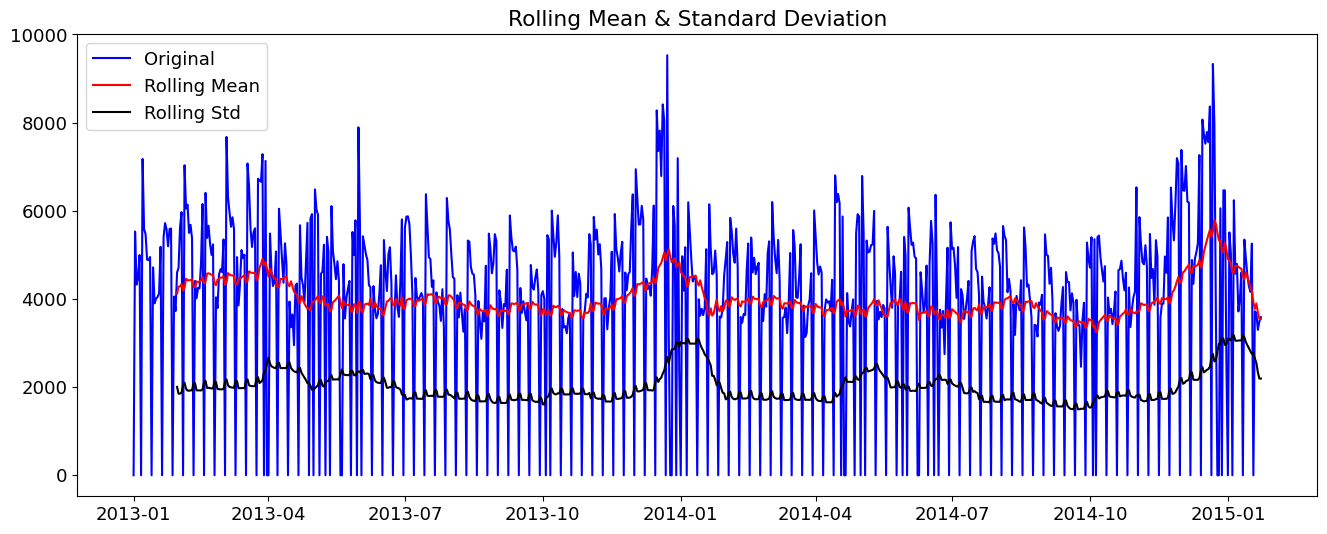

In [178]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

#Determing rolling statistics
rolmean = train_data[["Sales"]].rolling( window=30).mean()
rolstd = train_data[["Sales"]].rolling(window=30).std()

#Plot rolling statistics:
orig = axes.plot(train_data[["Sales"]], color='blue',label='Original')
mean = axes.plot(rolmean, color='red', label='Rolling Mean')
std = axes.plot(rolstd, color='black', label = 'Rolling Std')
axes.legend(loc='best')
axes.set_title('Rolling Mean & Standard Deviation')

### Check stationarity:

In [179]:
adf_test(train_data[["Sales"]])

ADF Statistic: -3.627864583541573
p-value: 0.005250125104946582
Critical Values:
	1%: -3.439314999916068
	5%: -2.8654965012008677
	10%: -2.5688768817372867
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [180]:
kpss_test(train_data[["Sales"]])

KPSS Statistic: 0.2099586392870777
p-value: 0.1
Lags Used: 3
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The data is stationary


/tmp/ipykernel_32/3039272199.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data,regression="c")


### <font color='green'>**In the first look, data seems to be non stationary. Despite that, the tests confirm that the data is stationary. The STD is high but is almost steady across all the winows**</font>

### Autocorrelatin Graphs

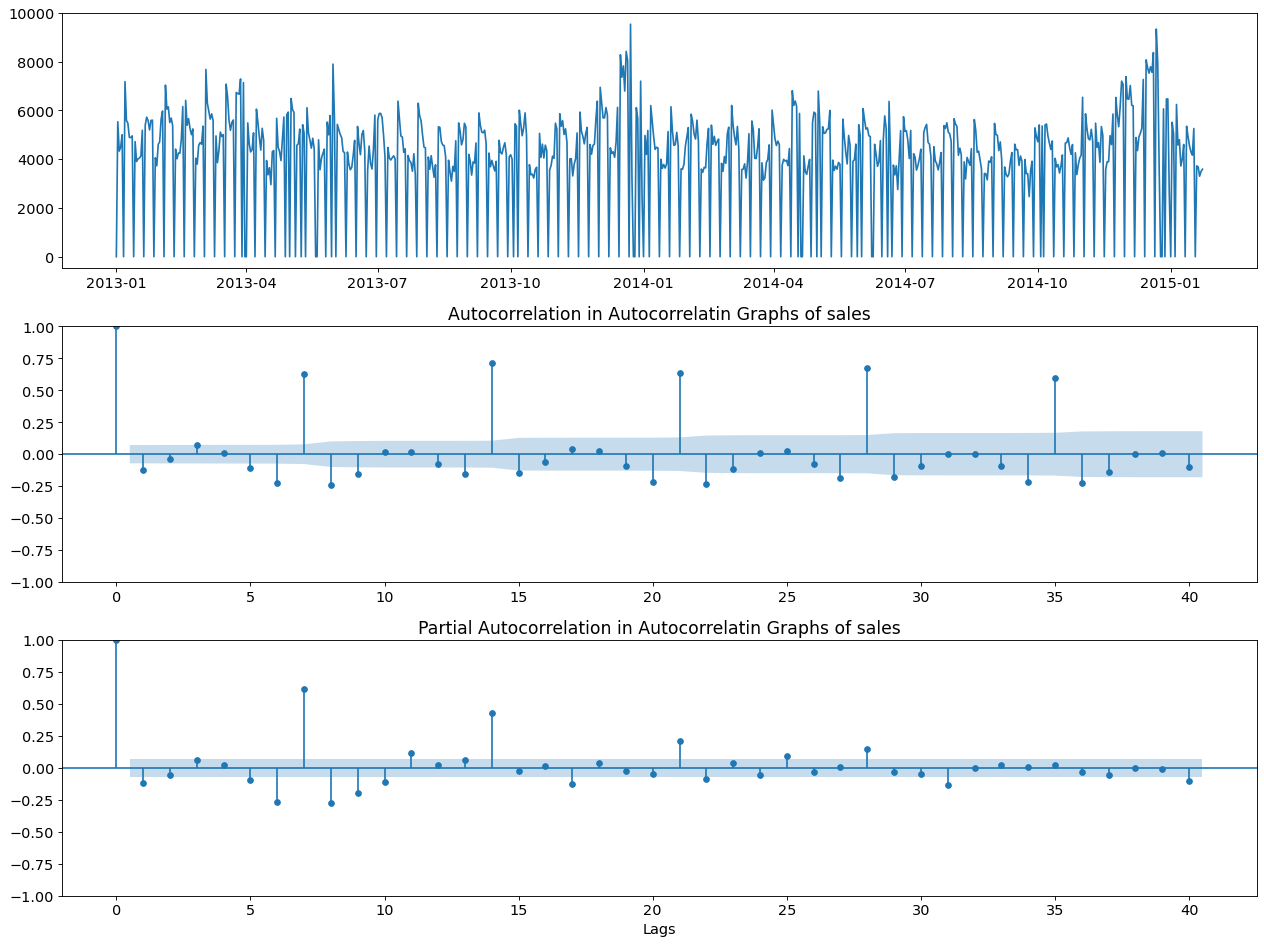

In [181]:
autocorrelatin_graphs(train_data[["Sales"]], n_lags=40, title_text="Autocorrelatin Graphs of sales")

### <font color='green'>**The ACF and PACF show a sine wave-like correlation pattern with high positive correlations at lag 7, 14, 21, and so on, it suggests the presence of a seasonal component in the data.**</font>

### Arima

In [373]:
# fit model
ARIMA_model = ARIMA(train_data[["Sales"]], order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()

In [374]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  753
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6799.437
Date:                Wed, 21 Jun 2023   AIC                          13604.874
Time:                        12:28:17   BIC                          13618.742
Sample:                    01-01-2013   HQIC                         13610.217
                         - 01-23-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1163      0.035     -3.347      0.001      -0.184      -0.048
ma.L1         -0.9999      0.079    -12.729      0.000      -1.154      -0.846
sigma2      4.142e+06   3.15e+05     13.162      0.000    3.53e+06    4.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                75.70
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.77
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [375]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
arima_preds = ARIMA_model_fit.predict(start=start_index, end=end_index)

### Make Value of prediction = 0 when The Store is not open

In [376]:
arima_preds[test_data["Open"] == 0] = 0

### Evaluate performance

In [377]:
print(f'RMSPE for Arima on test:{rmspe(arima_preds,test_data[["Sales"]])}')

RMSPE for Arima on test:0.2707639707994355


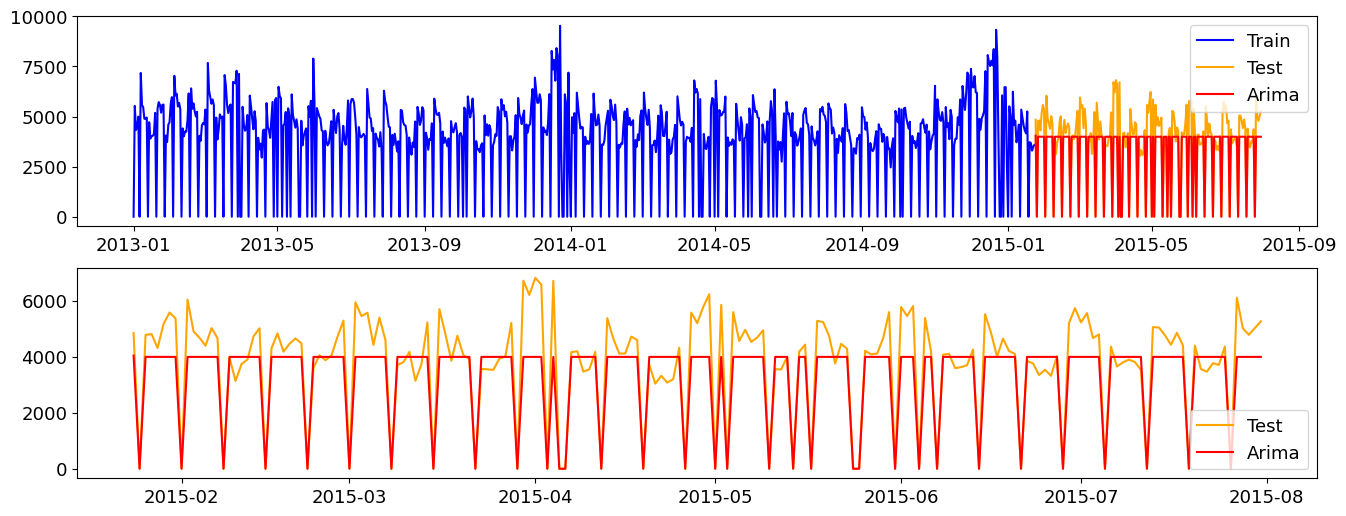

In [378]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(arima_preds,label="Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(arima_preds,label="Arima",color='red')
axes[1].legend(loc='best')
plt.show()

### SARIMAX

#### <font color='green'>**Considering the characteristics, an appropriate model to capture the seasonality and the sine wave-like patterns would be the SARIMA (Seasonal Autoregressive Integrated Moving Average) model. SARIMA is an extension of the ARIMA model that incorporates seasonal components.**</font>

In [440]:
# fit model
SARIMAX_model = SARIMAX(train_data[["Sales"]], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
SARIMAX_model_fit = SARIMAX_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58464D+00    |proj g|=  6.16807D-02


 This problem is unconstrained.



At iterate    5    f=  8.54030D+00    |proj g|=  8.82730D-03

At iterate   10    f=  8.53659D+00    |proj g|=  5.96065D-04

At iterate   15    f=  8.53628D+00    |proj g|=  7.96079D-04

At iterate   20    f=  8.53576D+00    |proj g|=  1.25671D-02

At iterate   25    f=  8.48375D+00    |proj g|=  1.69996D-01

At iterate   30    f=  8.41244D+00    |proj g|=  1.65765D-02

At iterate   35    f=  8.40704D+00    |proj g|=  4.97079D-03

At iterate   40    f=  8.40660D+00    |proj g|=  8.66547D-04

At iterate   45    f=  8.40654D+00    |proj g|=  1.02896D-03


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.40653D+00    |proj g|=  3.00951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   3.010D-04   8.407D+00
  F =   8.4065267967343846     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [441]:
SARIMAX_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  753
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -6330.115
Date:                           Wed, 21 Jun 2023   AIC                          12670.229
Time:                                   12:52:15   BIC                          12693.296
Sample:                               01-01-2013   HQIC                         12679.120
                                    - 01-23-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2127      0.020     10.853      0.000       0.174       0.251
ma.L1         -0.9488      0.009   -100.197      0.000      -0.967      -0.930
ar.S.L7       -0.0736      0.026     -2.800      0.005      -0.125      -0.022
ma.S.L7       -0.9987      0.027    -36.731      0.000      -1.052      -0.945
sigma2      1.339e+06    2.1e-08   6.37e+13      0.000    1.34e+06    1.34e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              1576.87
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.42
Prob(H) (two-sided):                  0.97   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.72e+27. Standard errors may be unstable.
"""

In [442]:
start_index = test_data.index.min()
end_index = test_data.index.max()

#Predictions
SARIMAX_preds = SARIMAX_model_fit.predict(start=start_index, end=end_index)

### Make Value of prediction = 0 when The Store is not open

In [443]:
SARIMAX_preds[test_data["Open"] == 0] = 0

In [444]:
print(f'RMSPE for SARIMAX on test:{rmspe(SARIMAX_preds,test_data[["Sales"]])}')

RMSPE for SARIMAX on test:0.19477443198317906


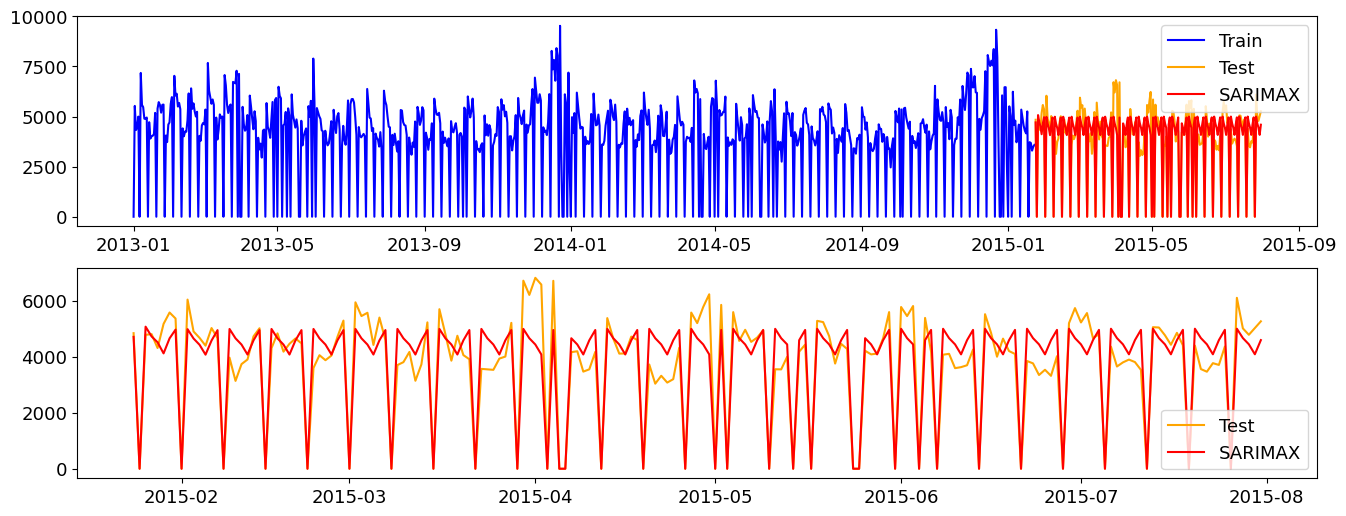

In [445]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(SARIMAX_preds,label="SARIMAX",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(SARIMAX_preds,label="SARIMAX",color='red')
axes[1].legend(loc='best')
plt.show()

### Auto Arima

In [416]:
stepwise_model = auto_arima(train_data[["Sales"]],start_p=1, start_q=1,d=1, max_p=3, max_q=3,
                            seasonal=True, start_P =1, start_Q=1, D=1, max_Q=3, max_P=3, max_order=12, m=7,
                            trace=True,stationary=True,error_action='ignore',
                            suppress_warnings=True, stepwise=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=4.46 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13621.052, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=13483.023, Time=1.26 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=13446.503, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14803.470, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=13611.017, Time=0.22 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=13269.196, Time=2.46 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=13266.485, Time=4.77 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=13215.196, Time=6.13 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=5.28 sec
 ARIMA(0,0,1)(3,0,2)[7] intercept   : AIC=inf, Time=11.68 sec
 ARIMA(0,0,1)(2,0,3)[7] intercept   : AIC=inf, Time=14.00 sec
 ARIMA(0,0,1)(1,0,3)[7] intercept   : AIC=13194.781, Time=9.62 sec
 ARIMA(0,0,1)(0,0,3)[7] intercept   : AIC=13199

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                  753
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -6573.097
Date:                                   Wed, 21 Jun 2023   AIC                          13162.194
Time:                                           12:50:04   BIC                          13199.187
Sample:                                       01-01-2013   HQIC                         13176.446
                                            - 01-23-2015                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4318.6949    819.134      5.272      0.000    2713.223    5924.167
ar.L1         -0.9385      0.125     -7.487      0.000      -1.184      -0.693
ma.L1          0.9134      0.135      6.768      0.000       0.649       1.178
ar.S.L7        0.5302      0.084      6.290      0.000       0.365       0.695
ma.S.L7       -0.0894      0.093     -0.962      0.336      -0.272       0.093
ma.S.L14       0.2849      0.051      5.636      0.000       0.186       0.384
ma.S.L21       0.1062      0.057      1.870      0.062      -0.005       0.218
sigma2      2.324e+06    1.1e+05     21.106      0.000    2.11e+06    2.54e+06
===================================================================================
Ljung-Box (L1) (Q):                  17.93   Jarque-Bera (JB):               114.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.45
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [417]:
length = len(test_data)

#Predictions
auto_arima_forecast,conf_int = stepwise_model.predict(n_periods=length,return_conf_int=True)

### Make Value of prediction = 0 when The Store is not open

In [418]:
auto_arima_forecast[test_data["Open"] == 0] = 0

In [419]:
print(f'RMSPE for Auto Arima on test:{rmspe(auto_arima_forecast,test_data[["Sales"]])}')

RMSPE for Auto Arima on test:0.19992644797593181


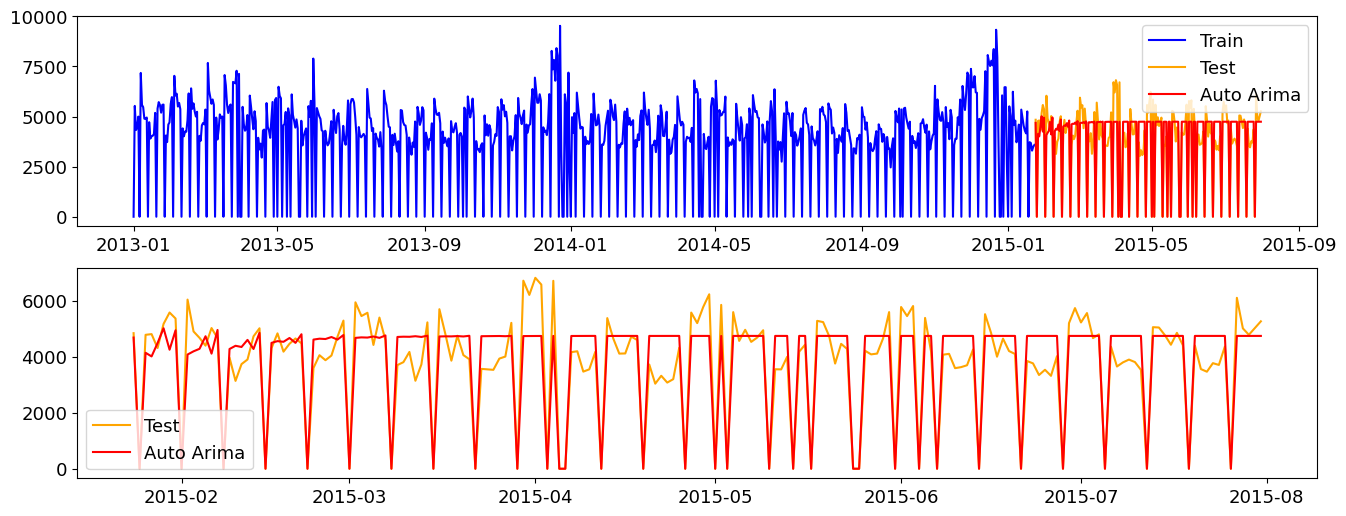

In [420]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(auto_arima_forecast,label="Auto Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(auto_arima_forecast,label="Auto Arima",color='red')
axes[1].legend(loc='best')
plt.show()

## **D- Prophet**

### Define preparing data function

In [249]:
def prepare_df_prophet(df, Type="train"):
    new_df = df.copy(deep=True)
    new_df.drop(["Store","StateHoliday"], inplace=True, axis=1)
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    new_df = new_df.reset_index()
    new_df.rename({"Sales": "y", "Date" : "ds"},axis=1, inplace = True)
    if Type == "test":
        new_df.drop("y", axis=1, inplace=True)
    return new_df

In [250]:
train_prophet = prepare_df_prophet(train_data)

In [251]:
train_prophet.columns

Index(['ds', 'DayOfWeek', 'y', 'Open', 'Promo', 'SchoolHoliday', 'Day',
       'Month', 'Year', 'DayOfYear', 'WeekOfYear'],
      dtype='object')

### Create model instance and adding all features as regressors

In [252]:
Prophet_model = Prophet()

regressors = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'DayOfYear', 'WeekOfYear']

for regressor in regressors:
    Prophet_model.add_regressor(regressor)

### Model fitting

In [253]:
Prophet_model.fit(train_prophet)

### Prepare test dataset

In [258]:
test_prophet = prepare_df_prophet(test_data, Type="test")

In [259]:
forecast = Prophet_model.predict(test_prophet)

In [260]:
prophet_preds = forecast.copy(deep=True)
prophet_preds = prophet_preds.set_index("ds")["yhat"].clip(lower=0)

### Make Value of prediction = 0 when The Store is not open

In [261]:
prophet_preds[test_data["Open"] == 0] = 0

### Evaluate performance

In [262]:
print(f'RMSPE for Prophet on Test:{rmspe(prophet_preds,test_data["Sales"])}')

RMSPE for Prophet on Test:0.14125369421456865


### Plot predictions

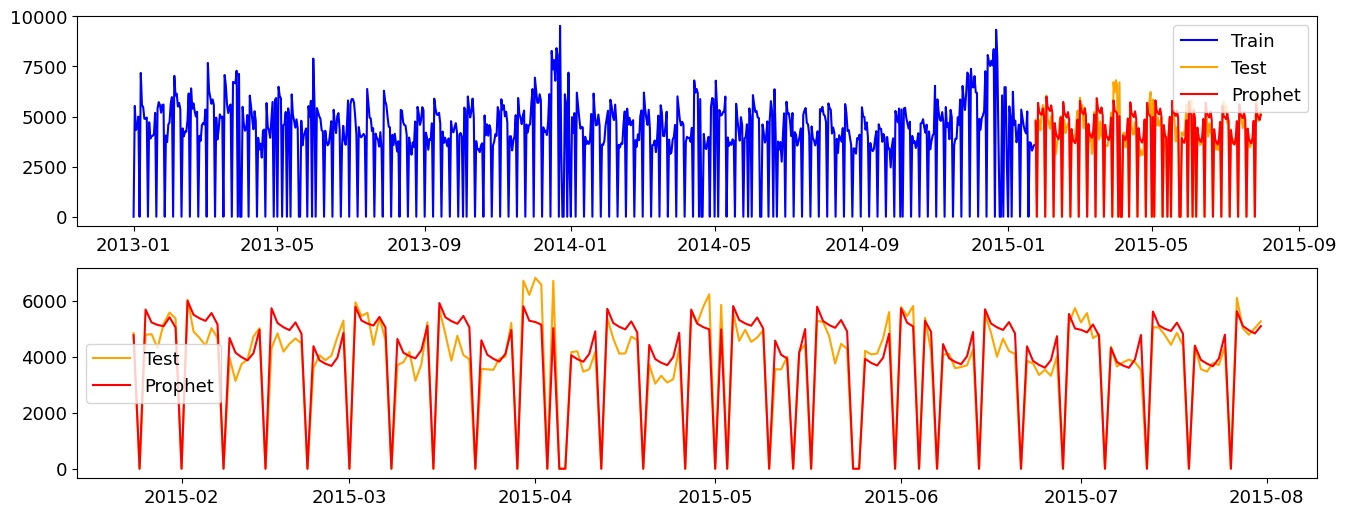

In [263]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(prophet_preds,label="Prophet",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(prophet_preds,label="Prophet",color='red')
axes[1].legend(loc='best')
plt.show()

### Fine Tuning

In [264]:
regressors = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'DayOfYear', 'WeekOfYear']

train_prophet = prepare_df_prophet(train_data)

test_prophet = prepare_df_prophet(test_data, Type="test")

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
    'changepoint_range': [0.8, 0.9, 1.0],
}

best_model = None
best_param = None
best_rmspe = float('inf')

# Iterate over all combinations of parameters
for params in tqdm(ParameterGrid(param_grid)):
    # Create a new Prophet model with the specified parameters
    model = Prophet(**params)

    # Add regressors to the model
    for regressor in regressors:
        model.add_regressor(regressor)

    # Fit the model to the training data
    model.fit(train_prophet)

    # Make predictions on the test data
    forecast = model.predict(test_prophet)
    prophet_preds = forecast.set_index("ds")["yhat"].clip(lower=0)
    prophet_preds[test_data["Open"] == 0] = 0

    # Calculate RMSPE
    rmspe_score = rmspe(prophet_preds, test_data["Sales"])

    # Check if the current model is the best so far
    if rmspe_score < best_rmspe:
        best_rmspe = rmspe_score
        print(f"  Found new best RMSPE: {best_rmspe}")
        best_model = model
        best_param = params

# Print the RMSPE of the best model
print(f"Best RMSPE: {best_rmspe}")
print(f"Best Params: {best_param}")

  0%|          | 1/225 [00:00<03:37,  1.03it/s]

  Found new best RMSPE: 0.1576602140926605


  1%|          | 2/225 [00:01<03:17,  1.13it/s]

  Found new best RMSPE: 0.14139588512770013


  5%|▍         | 11/225 [00:09<02:48,  1.27it/s]

  Found new best RMSPE: 0.14127041156196268


  7%|▋         | 15/225 [00:12<02:42,  1.30it/s]

  Found new best RMSPE: 0.14118234310901173


 61%|██████    | 137/225 [01:58<01:14,  1.18it/s]

  Found new best RMSPE: 0.13927859547048266


 61%|██████▏   | 138/225 [01:59<01:11,  1.21it/s]

  Found new best RMSPE: 0.13858551171807024


 84%|████████▎ | 188/225 [02:45<00:34,  1.06it/s]

  Found new best RMSPE: 0.13846126661838684


 94%|█████████▍| 211/225 [03:07<00:14,  1.02s/it]

  Found new best RMSPE: 0.1363970866261969


 95%|█████████▌| 214/225 [03:09<00:10,  1.06it/s]

  Found new best RMSPE: 0.13629700346926127


 96%|█████████▋| 217/225 [03:12<00:07,  1.00it/s]

  Found new best RMSPE: 0.1361466602677772


100%|██████████| 225/225 [03:20<00:00,  1.12it/s]

Best RMSPE: 0.1361466602677772
Best Params: {'changepoint_prior_scale': 0.5, 'changepoint_range': 1.0, 'holidays_prior_scale': 0.3, 'seasonality_prior_scale': 0.01}


In [265]:
forecast = best_model.predict(test_prophet)

### Evaluate performance of best model

In [266]:
prophet_preds = forecast.copy(deep=True)
prophet_preds = prophet_preds.set_index("ds")["yhat"].clip(lower=0)
print(f'RMSPE for Prophet on Test:{rmspe(prophet_preds,test_data["Sales"])}')

RMSPE for Prophet on Test:0.13661244626193184


### Plot predictions of best model

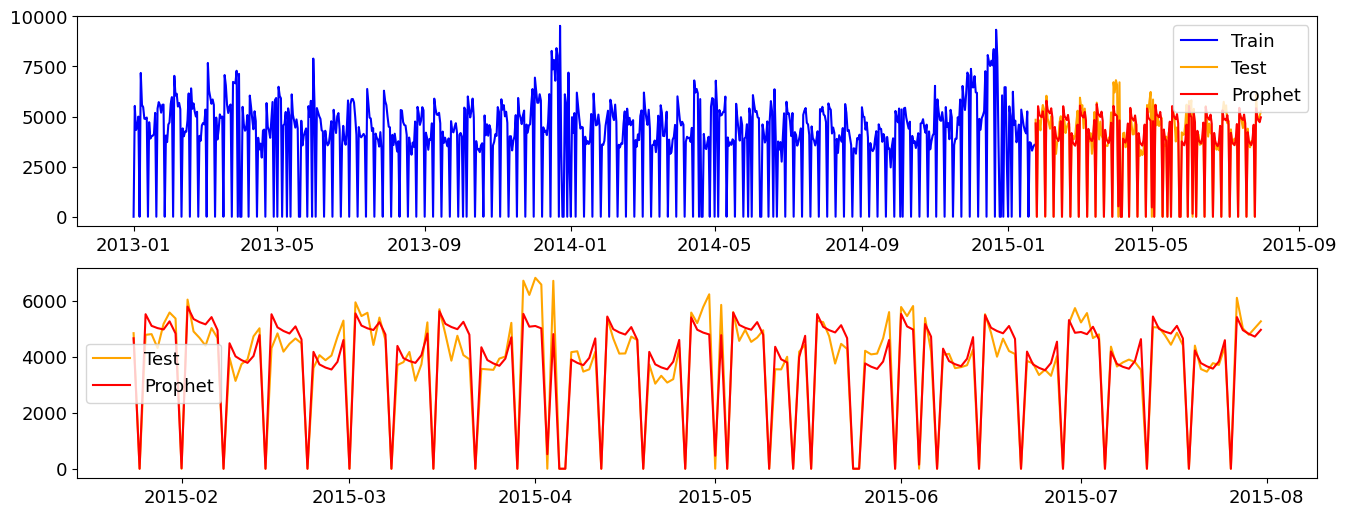

In [267]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(prophet_preds,label="Prophet",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(prophet_preds,label="Prophet",color='red')
axes[1].legend(loc='best')
plt.show()

---

# 7. <a name="7">**Machine Learning model**</a>
(<a href="#0">Go to top</a>)

In [277]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

### Prepare df function

In [278]:
def prepare_df_ml(df):
    new_df = df.copy(deep=True)
    new_df.drop(["Store","StateHoliday"], inplace=True, axis=1)
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    df_prep_X = new_df.drop("Sales", axis=1)
    df_prep_Y = new_df["Sales"]
    return df_prep_X, df_prep_Y

### Prepare training data

In [279]:
train_prep_X, train_prep_Y = prepare_df_ml(train_data)

In [280]:
train_prep_X.head()

,DayOfWeek,Open,Promo,SchoolHoliday,Day,Month,Year,DayOfYear,WeekOfYear
Date,,,,,,,,,
2013-01-01,2,0,0,1,1,1,2013,1,1
2013-01-02,3,1,0,1,2,1,2013,2,1
2013-01-03,4,1,0,1,3,1,2013,3,1
2013-01-04,5,1,0,1,4,1,2013,4,1
2013-01-05,6,1,0,1,5,1,2013,5,1


In [281]:
train_prep_Y

Date
2013-01-01       0
2013-01-02    5530
2013-01-03    4327
2013-01-04    4486
2013-01-05    4997
              ... 
2015-01-19    3721
2015-01-20    3680
2015-01-21    3299
2015-01-22    3492
2015-01-23    3586
Freq: D, Name: Sales, Length: 753, dtype: int64

### Model fitting

In [282]:
lgbm_model = LGBMRegressor(random_state=42)

In [283]:
train_prep_X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2013-01-01 to 2015-01-23
Freq: D
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   DayOfWeek      753 non-null    int64
 1   Open           753 non-null    int64
 2   Promo          753 non-null    int64
 3   SchoolHoliday  753 non-null    int64
 4   Day            753 non-null    int64
 5   Month          753 non-null    int64
 6   Year           753 non-null    int64
 7   DayOfYear      753 non-null    int64
 8   WeekOfYear     753 non-null    int64
dtypes: int64(9)
memory usage: 58.8 KB


In [284]:
lgbm_model.fit(train_prep_X, train_prep_Y)

LGBMRegressor(random_state=42)

### Performance on train

In [285]:
lgbm_train_preds = lgbm_model.predict(train_prep_X)
lgbm_train_preds = pd.Series(lgbm_train_preds, index= train_prep_X.index)
lgbm_train_preds = lgbm_train_preds.clip(lower=0)
lgbm_train_preds[train_prep_X["Open"] == 0] = 0
print(f'RMSPE for LGBM on Train:{rmspe(lgbm_train_preds,train_prep_Y)}')

RMSPE for LGBM on Train:0.07557671067339185


### Prepare testing data

In [286]:
test_prep_X, test_prep_Y = prepare_df_ml(test_data)

In [287]:
test_prep_X

,DayOfWeek,Open,Promo,SchoolHoliday,Day,Month,Year,DayOfYear,WeekOfYear
Date,,,,,,,,,
2015-01-24,6,1,0,0,24,1,2015,24,4
2015-01-25,7,0,0,0,25,1,2015,25,4
2015-01-26,1,1,1,0,26,1,2015,26,5
2015-01-27,2,1,1,0,27,1,2015,27,5
2015-01-28,3,1,1,0,28,1,2015,28,5
...,...,...,...,...,...,...,...,...,...
2015-07-27,1,1,1,1,27,7,2015,208,31
2015-07-28,2,1,1,1,28,7,2015,209,31
2015-07-29,3,1,1,1,29,7,2015,210,31


In [288]:
lgbm_preds = lgbm_model.predict(test_prep_X)

### Performance on test

In [289]:
lgbm_test_preds = lgbm_model.predict(test_prep_X)
lgbm_test_preds = pd.Series(lgbm_test_preds, index= test_prep_X.index)
lgbm_test_preds = lgbm_test_preds.clip(lower=0)
lgbm_test_preds[test_prep_X["Open"] == 0] = 0
print(f'RMSPE for LGBM on Test:{rmspe(lgbm_test_preds,test_prep_Y)}')

RMSPE for LGBM on Test:0.1080306113018498


### Plot predictions

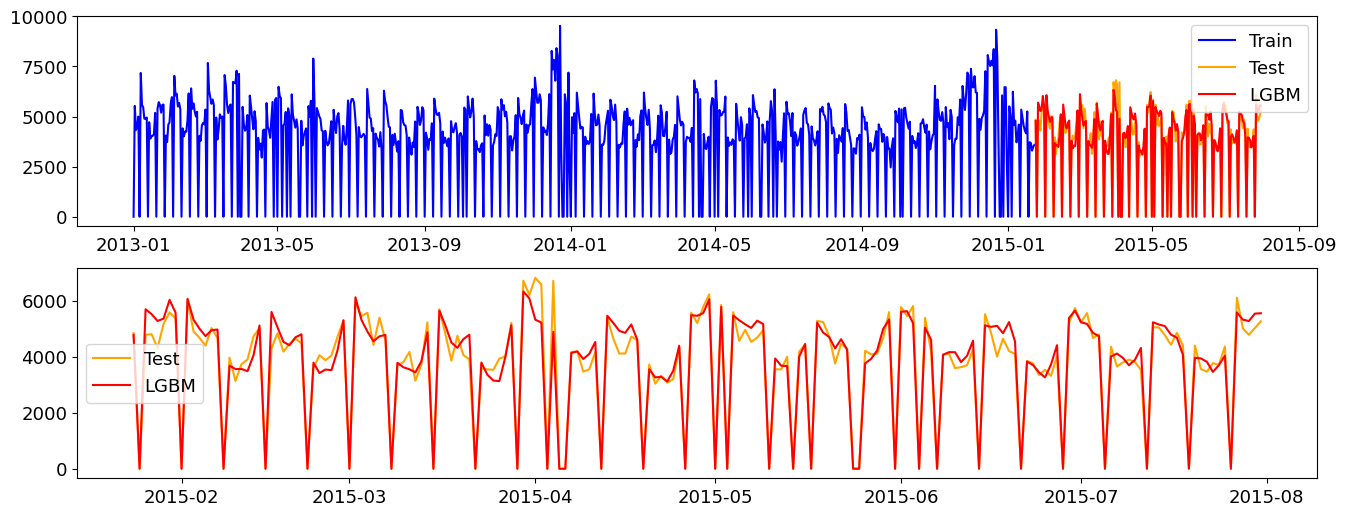

In [290]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(lgbm_test_preds,label="LGBM",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(lgbm_test_preds,label="LGBM",color='red')
axes[1].legend(loc='best')
plt.show()

### Fine Tuning

In [291]:
# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1],  # Learning rate for boosting
    'n_estimators': [100, 200, 300],  # Number of boosting iterations
    'reg_alpha': [0.0, 0.1, 0.5],  # L1 regularization term on weights
    'reg_lambda': [0.0, 0.1, 0.5],  # L2 regularization term on weights
    'max_depth': [-1, 5, 10],  # Maximum depth of a tree
}

# Generate all possible combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

# Create lists to store the results
best_params = None
best_model = None
best_rmspe = float('inf')

# Iterate over each parameter combination
for params in tqdm(param_combinations):
    # Create the LGBMRegressor model with the current hyperparameters
    lgbm_model = LGBMRegressor(random_state=42, **dict(zip(param_grid.keys(), params)))
    
    # Fit the model to the training data
    lgbm_model.fit(train_prep_X, train_prep_Y)
    
    # Make predictions on the test data
    lgbm_test_preds = lgbm_model.predict(test_prep_X)
    lgbm_test_preds = pd.Series(lgbm_test_preds, index=test_prep_X.index)
    lgbm_test_preds = lgbm_test_preds.clip(lower=0)
    lgbm_test_preds[test_prep_X["Open"] == 0] = 0
    # Calculate RMSPE
    rmspe_value = rmspe(lgbm_test_preds, test_prep_Y)
    
    # Check if the current model has the best RMSPE
    if rmspe_value < best_rmspe:
        best_rmspe = rmspe_value
        print(f"  Found new best RMSPE: {best_rmspe}")
        best_params = params
        best_model = lgbm_model

# Print the best hyperparameters and RMSPE
print(f"Best Parameters: {dict(zip(param_grid.keys(), best_params))}")
print(f"RMSPE for Best LGBM on Test: {best_rmspe}")

  1%|          | 1/162 [00:00<01:59,  1.35it/s]

  Found new best RMSPE: 0.13565673371896111


 17%|█▋        | 28/162 [00:11<01:06,  2.00it/s]

  Found new best RMSPE: 0.11797296952724887


 19%|█▉        | 31/162 [00:13<01:26,  1.52it/s]

  Found new best RMSPE: 0.11796885213769676


 34%|███▍      | 55/162 [00:30<01:31,  1.17it/s]

  Found new best RMSPE: 0.11220563446962013


 40%|███▉      | 64/162 [00:40<01:48,  1.10s/it]

  Found new best RMSPE: 0.11220240170399404


 51%|█████     | 82/162 [00:57<01:08,  1.16it/s]

  Found new best RMSPE: 0.1080306113018498


 51%|█████     | 83/162 [00:57<00:52,  1.49it/s]

  Found new best RMSPE: 0.10394196981842323


100%|██████████| 162/162 [01:56<00:00,  1.39it/s]

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'max_depth': 5}
RMSPE for Best LGBM on Test: 0.10394196981842323


### Performance of best model

In [292]:
lgbm_test_preds = best_model.predict(test_prep_X)
lgbm_test_preds = pd.Series(lgbm_test_preds, index= test_prep_X.index)
lgbm_test_preds = lgbm_test_preds.clip(lower=0)
lgbm_test_preds[test_prep_X["Open"] == 0] = 0
print(f'RMSPE for LGBM on Test:{rmspe(lgbm_test_preds,test_prep_Y)}')

RMSPE for LGBM on Test:0.10394196981842323


### Plot predictions of best model

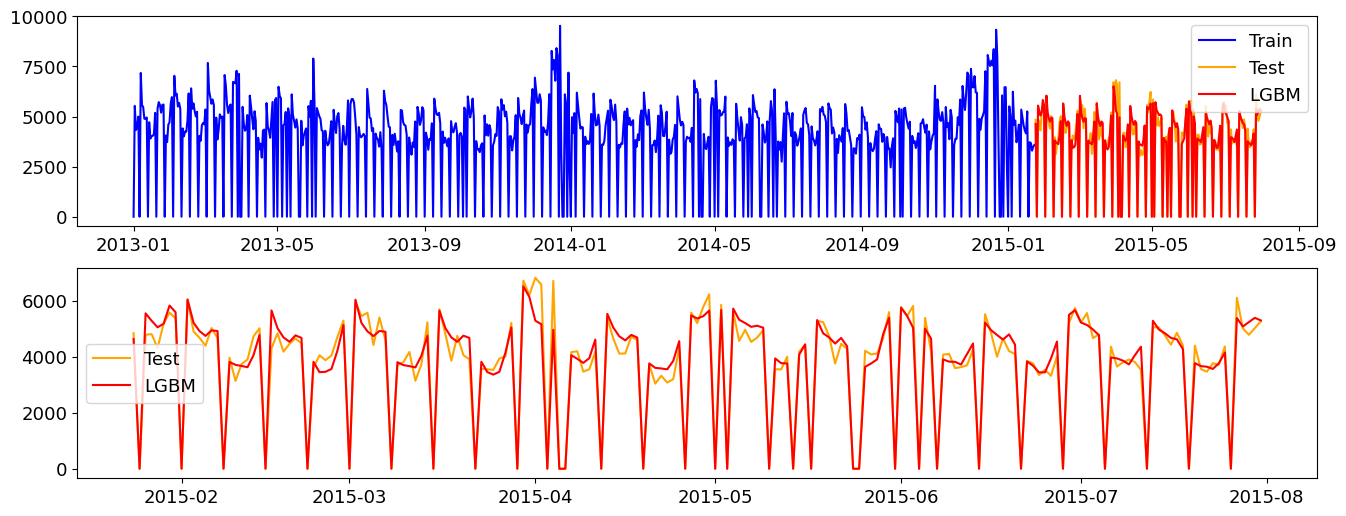

In [293]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data["Sales"], label='Train',color='blue')
axes[0].plot(test_data["Sales"], label='Test',color='orange')

axes[0].plot(lgbm_test_preds,label="LGBM",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(lgbm_test_preds,label="LGBM",color='red')
axes[1].legend(loc='best')
plt.show()

---

# 8. <a name="8">**Choosing Best Model**</a>
(<a href="#0">Go to top</a>)

| Method                        | RMSPE                    | Model Type      |
|-------------------------------|-------------------------|------------------|
| **LGBM**                      | **0.1039**              | **ML**           |
| Prophet                       | 0.1366                  | Time Series      |
| SARIMAX                       | 0.1947                  | Time Series      |
| Auto Arima                    | 0.1999                  | Time Series      |
| average method                | 0.2700                  | Simple Model     |
| Arima                         | 0.2707                  | Time Series      |
| Seasonal Naive method         | 0.2785                  | Simple Model     |
| Naive method                  | 0.3849                  | Simple Model     |
| Drift method                  | 0.4765                  | Simple Model     |


## Summary

**The LGBM model outperformed other models in the competition, indicating that the provided features have significant predictive power for sales forecasting. The time series models, including Prophet, SARIMAX and Auto ARIMA, performed reasonably well but were less accurate than the LGBM model. The simple models, such as the average method and the Seasonal Naive method, provided baseline performance, while the Naive method, and Drift method showed relatively higher errors, suggesting limitations in capturing the complexities of the sales data.**

## <font color='green'>**Best model: LGBM Regressor**</font>

**The best-performing model in terms of RMSPE (Root Mean Square Percentage Error) is the LightGBM (LGBM) model, with an RMSPE of 0.1039. LGBM is a gradient boosting framework that uses decision trees as base learners. Its strong performance suggests that the features provided in the dataset have significant predictive power, and the LGBM model effectively captures the relationships between these features and the sales data.**

## <font color='green'>**Second Best model: Prophet**</font>

**The second-best model is Prophet, a time series forecasting model developed by Facebook, with an RMSPE of 0.1366. Prophet is known for its ability to handle various time series patterns such as seasonality, trends, and holidays. Its slightly higher error compared to LGBM may be due to the nature of the data, where the predictive features utilized by LGBM might be better suited for capturing the sales patterns.**

---